### final project - melody azran

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

In [2123]:
train_x = pd.read_csv('train.csv')

In [2124]:
test_x = pd.read_csv('test.csv')

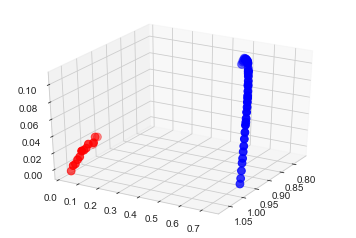

In [2125]:
# plot few paths
first_traj = train_x[train_x['traj_ind']==1]
second_traj = train_x[train_x['traj_ind']==14]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_traj['x'], first_traj['y'], first_traj['z'], c='red', s=60)
ax.scatter(second_traj['x'], second_traj['y'], second_traj['z'], c='blue', s=60)
ax.view_init(30, 30)
plt.show()

In [2126]:
train_x['label'].value_counts()

0    687296
1    218633
2    122049
Name: label, dtype: int64

In [2127]:
#check if there any missing values.
train_x.isnull().sum()

label         0
time_stamp    0
traj_ind      0
x             0
y             0
z             0
dtype: int64

### features extraction 

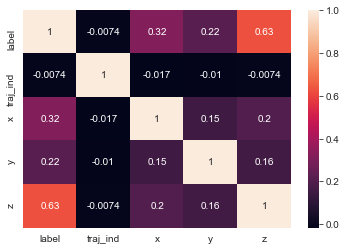

In [2128]:
#check correlation
sns.set_style("whitegrid")
sns.heatmap(train_x.corr(), annot=True)

In [81]:
def add_max_cordinate(df,cordinate='z'):
    max_feat_by_traj_id = pd.DataFrame(df.groupby('traj_ind')[cordinate].max()).reset_index()
    max_feat_by_traj_id = max_feat_by_traj_id.rename(columns = {cordinate:'max_'+ cordinate})
    df = df.merge(max_feat_by_traj_id, left_on='traj_ind',right_on='traj_ind' )
    return df

def add_min_cordinate(df,cordinate='z'):
    max_feat_by_traj_id = pd.DataFrame(df.groupby('traj_ind')[cordinate].min()).reset_index()
    max_feat_by_traj_id = max_feat_by_traj_id.rename(columns = {cordinate:'min_'+ cordinate})
    df = df.merge(max_feat_by_traj_id, left_on='traj_ind',right_on='traj_ind' )
    return df

In [82]:
def add_distances_x_y_start_to_end(df):
    df = df.sort_values(by=['traj_ind','time_stamp'])
    distances_per_traj_ind = {}
    for i in df['traj_ind'].unique():
        x1 = df[df['traj_ind']==i].tail(1)['x']
        x2 = df[df['traj_ind']==i].head(1)['x']
        y1 = df[df['traj_ind']==i].tail(1)['y']
        y2 = df[df['traj_ind']==i].head(1)['y']

        d2 = np.square( x2.values - x1.values )  + np.square( y2.values - y1.values ) 
        distances = np.sqrt( d2 )
        distances_per_traj_ind[i] = distances

    distances_per_traj_ind_df = pd.DataFrame(distances_per_traj_ind).T
    distances_per_traj_ind_df = distances_per_traj_ind_df.reset_index().rename(columns={'index':'traj_ind'})
    
    df = df.merge(distances_per_traj_ind_df, on='traj_ind')
    df = df.rename(columns={0:'distance_x_y'})
    return df

In [83]:
def calculate_starting_angle(df):
    angle_per_traj_ind = []
    for i in df['traj_ind'].unique():
        print
        if(len(df[df['traj_ind']==i])>=3):
            a = np.array(df[df['traj_ind']==i].head(3).reset_index().iloc[0][['x','y','z']])
            b = np.array(df[df['traj_ind']==i].head(3).reset_index().iloc[1][['x','y','z']])
            c = np.array(df[df['traj_ind']==i].head(3).reset_index().iloc[2][['x','y','z']])


            ba = a - b
            bc = c - b

            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            angle = np.arccos(cosine_angle)

            angle_per_traj_ind.append([i,angle])
            
        else:
            angle_per_traj_ind.append([i,np.nan])     
    angle_per_traj_ind = pd.DataFrame(angle_per_traj_ind)
    angle_per_traj_ind = angle_per_traj_ind.rename(columns={0:'traj_ind'})
    angle_per_traj_ind = angle_per_traj_ind.iloc[:,0:2]
    df = df.merge(angle_per_traj_ind, on='traj_ind')
    df.columns = [*df.columns[:-1], 'strating_angle']
    return df

In [84]:
def time_to_pick(df):
    import datetime
    from datetime import date
    
    df['time_to_peak'] = np.nan
    for i in df['traj_ind'].unique():
        #print('starting ' + str(i) )
        time_peak = df[(df['traj_ind']==i) & (df['z']==df['max_z'])]['time_stamp'] 
        time_start = df[df['traj_ind']==i].head(1)['time_stamp'] 
        if(str(time_peak)==str(time_start)):
            miliseconds=0
        else:
            delta = time_peak - time_start
            #df.loc[df['traj_ind']==i, 'time_to_peak'] = delta.microseconds
            time_peak = datetime.datetime.strptime(str(time_peak.values[0]), '%Y-%m-%d %H:%M:%S.%f')
            time_start = datetime.datetime.strptime(str(time_start.values[0]), '%Y-%m-%d %H:%M:%S.%f')

            #print(time_peak , time_start)
            delta = time_peak - time_start
            #print(i,delta)
            miliseconds = delta.microseconds
        df.loc[df['traj_ind']==i, 'time_to_peak'] = miliseconds
    return df

In [990]:
def add_distances_x_z_start_to_end(df):
    df = df.sort_values(by=['traj_ind','time_stamp'])
    distances_per_traj_ind = {}
    for i in df['traj_ind'].unique():
        x1 = df[df['traj_ind']==i].tail(1)['x']
        x2 = df[df['traj_ind']==i].head(1)['x']
        y1 = df[df['traj_ind']==i].tail(1)['z']
        y2 = df[df['traj_ind']==i].head(1)['z']

        d2 = np.square( x2.values - x1.values )  + np.square( y2.values - y1.values ) 
        distances = np.sqrt( d2 )
        distances_per_traj_ind[i] = distances

    distances_per_traj_ind_df = pd.DataFrame(distances_per_traj_ind).T
    distances_per_traj_ind_df = distances_per_traj_ind_df.reset_index().rename(columns={'index':'traj_ind'})
    
    df = df.merge(distances_per_traj_ind_df, on='traj_ind')
    df = df.rename(columns={0:'distance_x_z'})
    return df

In [85]:
def add_instances_count(df):
    instances_count_by_traj = df.groupby('traj_ind').count()['x'].reset_index()
    instances_count_by_traj.rename(columns={'x':'count_instances'} , inplace=True)
    df = df.merge(instances_count_by_traj, on='traj_ind')
    return df

In [86]:
for feat in ['x','y','z']:
    train_x = add_max_cordinate(train_x,feat)
    train_x = add_min_cordinate(train_x,feat)
    test_x = add_max_cordinate(test_x,feat)
    test_x = add_min_cordinate(test_x,feat)

In [87]:
#train_x = time_to_pick(train_x)

In [88]:
#test_x = time_to_pick(test_x)

In [89]:
train_x = add_distances_x_y_start_to_end(train_x)

In [90]:
test_x = add_distances_x_y_start_to_end(test_x)

In [91]:
#train_x = calculate_starting_angle(train_x)

In [92]:
#test_x = calculate_starting_angle(test_x)

In [93]:
train_x = add_instances_count(train_x)
test_x = add_instances_count(test_x)

In [992]:
#train_x = add_distances_x_z_start_to_end(train_x)

In [993]:
#test_x = add_distances_x_z_start_to_end(test_x)

In [109]:
#train_x

### Find anomaly

In [114]:
dict_anomaly ={}

dict_anomaly['std_each_feature_label_0'] = train_x[train_x['label']==0].iloc[:,3:].std()
dict_anomaly['mean_each_feature_label_0'] = train_x[train_x['label']==0].iloc[:,3:].mean()

dict_anomaly['std_each_feature_label_1'] = train_x[train_x['label']==1].iloc[:,3:].std()
dict_anomaly['mean_each_feature_label_1'] = train_x[train_x['label']==1].iloc[:,3:].mean()

dict_anomaly['std_each_feature_label_2'] = train_x[train_x['label']==2].iloc[:,3:].std()
dict_anomaly['mean_each_feature_label_2'] = train_x[train_x['label']==2].iloc[:,3:].mean()

In [118]:
dict_anomaly['std_each_feature_label_2']

x                   0.360603
y                   0.387632
z                   0.095130
max_x               0.361914
min_x               0.347785
max_y               0.375471
min_y               0.387743
max_z               0.096259
min_z               0.049071
distance_x_y        0.232331
count_instances    19.716072
dtype: float64

In [119]:
train_x['grade_anomaly'] = 0
for i in range(3):
    grade_anomaly = train_x[train_x['label']==i].apply(lambda x: abs((x[3:-1] - dict_anomaly['mean_each_feature_label_'+str(i)]) / dict_anomaly['std_each_feature_label_'+str(i)]).sum(),axis=1)
    train_x.loc[train_x['label']==i, 'grade_anomaly'] = grade_anomaly
    

In [124]:
#save data
train_x.to_pickle("data_train.pkl")
test_x.to_pickle("data_test.pkl")

In [2130]:
#sns.boxplot(y = train_x['grade_anomaly'] , x=train_x['label'])

In [128]:
#train_x[train_x['label']==1]['grade_anomaly'].describe()

In [2083]:
#load data
train_x = pd.read_pickle("data_train.pkl")
real_test = pd.read_pickle("data_test.pkl")

In [2084]:
real_test.head()

,time_stamp,traj_ind,x,y,z,max_x,min_x,max_y,min_y,max_z,min_z,distance_x_y,count_instances
0,2018-03-13 17:32:36.771156,49448,0.511826,0.119230,0.028492,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28
1,2018-03-13 17:32:36.821156,49448,0.512299,0.125603,0.029254,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28
2,2018-03-13 17:32:36.871156,49448,0.513160,0.131288,0.033442,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28
3,2018-03-13 17:32:36.921156,49448,0.513544,0.137606,0.033172,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28
4,2018-03-13 17:32:36.971156,49448,0.514440,0.143319,0.034603,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28


In [2085]:
len(train_x)

1027978

In [2086]:
len_label_0 = len(train_x[train_x['label']==0])
len_label_1 = len(train_x[train_x['label']==1])
len_label_2 = len(train_x[train_x['label']==2])

train_x_copy = train_x.copy()

index_anomaly = train_x[train_x['label']==0].nlargest(int(len_label_0*0.1) , 'grade_anomaly')['traj_ind'].unique()
index_anomaly2 = train_x[train_x['label']==1].nlargest(int(len_label_1*0.015) , 'grade_anomaly')['traj_ind'].unique()
index_anomaly3 = train_x[train_x['label']==2].nlargest(int(len_label_2*0.015) , 'grade_anomaly')['traj_ind'].unique()

train_x_copy = train_x_copy[~train_x_copy['traj_ind'].isin(index_anomaly)]
train_x_copy = train_x_copy[~train_x_copy['traj_ind'].isin(index_anomaly2)]
train_x_copy = train_x_copy[~train_x_copy['traj_ind'].isin(index_anomaly3)]

In [2087]:
train_x = train_x_copy

In [2088]:
#train_x[train_x['count_instances']==1]['label'].value_counts()

In [2089]:
### major = 1

In [2090]:
#sns.boxplot(train_x[train_x['count_instances']==1]['label'] , train_x[train_x['count_instances']==1]['y'])

In [2091]:
#deal with 1 instances :

In [2092]:
#train_x.loc[train_x['count_instances']==1,'label']  = train_x[train_x['count_instances']==1].apply(lambda x: 2 if x['y']>0.35 else 1, axis=1)

In [2093]:
#train_x[train_x['count_instances']==1]['label'].value_counts()

In [2094]:
# import os
# os.remove("data.pkl")

In [2095]:
#train_x_norm['strating_angle'] = train_x_norm['strating_angle']*100

In [2096]:
#train_x['xyz_mul'] = train_x['x']*train_x['y']*train_x['z']
#real_test['xyz_mul'] = real_test['x']*real_test['y']*real_test['z']
train_x['combine_distance_max_z'] = train_x['distance_x_y']*train_x['max_z']
real_test['combine_distance_max_z'] = real_test['distance_x_y']*real_test['max_z']

In [2097]:
real_test.head()

,time_stamp,traj_ind,x,y,z,max_x,min_x,max_y,min_y,max_z,min_z,distance_x_y,count_instances,combine_distance_max_z
0,2018-03-13 17:32:36.771156,49448,0.511826,0.119230,0.028492,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28,0.00689
1,2018-03-13 17:32:36.821156,49448,0.512299,0.125603,0.029254,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28,0.00689
2,2018-03-13 17:32:36.871156,49448,0.513160,0.131288,0.033442,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28,0.00689
3,2018-03-13 17:32:36.921156,49448,0.513544,0.137606,0.033172,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28,0.00689
4,2018-03-13 17:32:36.971156,49448,0.514440,0.143319,0.034603,0.515667,0.501833,0.280242,0.11923,0.042708,0.005822,0.161323,28,0.00689


In [2098]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
train_x = train_x.fillna(0)

In [2099]:
x_features = ['max_x','max_z','min_z' ,'distance_x_y','count_instances','label']#,'strating_angle','time_to_peak']
y_features = ['max_x','max_z','min_z' ,'distance_x_y','count_instances','traj_ind']#,'strating_angle','time_to_peak']

In [2100]:
save_traj_ind = real_test[y_features].drop_duplicates()['traj_ind']

In [2101]:
real_test = real_test[y_features[:-1]].drop_duplicates()

In [2102]:
train_x = train_x[x_features].drop_duplicates()

In [2103]:
real_test.head()

,max_x,max_z,min_z,distance_x_y,count_instances
0,0.515667,0.042708,0.005822,0.161323,28
28,0.515618,0.042919,0.005669,0.160741,28
56,0.481217,0.072321,-0.007109,0.243365,38
94,0.481364,0.072070,-0.007255,0.243100,38
132,0.481268,0.072237,-0.006875,0.243238,38


In [2104]:
# this part was for validation (not including in this notebook anymore..)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train_x.drop('label', axis=1), train_x['label'], test_size=0.2)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)

# len(X_test)

In [2106]:
Y = train_x['label']
train_x_norm = scaler.fit_transform(train_x.drop('label', axis=1))
real_test = scaler.transform(real_test)

In [2107]:
X = pd.DataFrame(train_x_norm, columns=x_features[:-1])

In [2111]:
Y = pd.get_dummies(Y)

In [2112]:
real_test.shape

(8020, 5)

In [2118]:
from keras.models import Sequential
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Conv1D
#LEARNING_RATE =0.005

# define the keras model (fc)
model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=7, activation='relu',input_dim=X.shape[1] ))
model.add(Dense(60, activation='relu', input_dim=X.shape[1]))
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='softmax'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset

In [2119]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_x['label']),
                                                 train_x['label'])

In [2120]:
class_weights

array([0.51547168, 1.22166854, 4.14118806])

In [2121]:
model.fit(X, Y, epochs=50, batch_size=120, class_weight=class_weights)

Epoch 1/50
29419/29419 [==============================] - 4s 141us/step - loss: 0.3938 - accuracy: 0.8091
Epoch 2/50
29419/29419 [==============================] - 2s 68us/step - loss: 0.1921 - accuracy: 0.9170
Epoch 3/50
29419/29419 [==============================] - 2s 66us/step - loss: 0.1700 - accuracy: 0.9370
Epoch 4/50
29419/29419 [==============================] - 2s 65us/step - loss: 0.1597 - accuracy: 0.9396
Epoch 5/50
29419/29419 [==============================] - 2s 67us/step - loss: 0.1545 - accuracy: 0.9409
Epoch 6/50
29419/29419 [==============================] - 2s 66us/step - loss: 0.1514 - accuracy: 0.9421
Epoch 7/50
29419/29419 [==============================] - 2s 65us/step - loss: 0.1505 - accuracy: 0.9427
Epoch 8/50
29419/29419 [==============================] - 2s 64us/step - loss: 0.1480 - accuracy: 0.9431
Epoch 9/50
29419/29419 [==============================] - 2s 64us/step - loss: 0.1491 - accuracy: 0.9427
Epoch 10/50
29419/29419 [=============================

In [2043]:
results_predictions = model.predict_proba(real_test)

In [2044]:
c = pd.DataFrame(results_predictions, index=save_traj_ind)

In [2045]:
c = c.reset_index().rename(columns={'traj_ind':'trajectory_ind' ,0:'type_0',1:'type_1',2:'type_2'})

In [2047]:
c.to_csv('subs/final_result_v6.csv' , index=False)

#### try to improve the result by changing the labels of the 'uncertain' preditions of type_0 

In [1994]:
best = pd.read_csv('final_result_v6.csv')

In [1996]:
best[1:].idxmax(axis=0)

traj_ind    8019
0           2778
1           1525
2            219
dtype: int64

In [1997]:
best['true_label'] = best.apply(lambda x: x[1:].idxmax() , axis=1)

In [1999]:
traj_for_change = best[(best['true_label']=='0') & (best['0']<0.6)]['traj_ind']
fix_indexs = best[(best['true_label']=='0') & (best['0']<0.6)].index

In [2000]:
zeros = best.iloc[fix_indexs]['0']
ones = best.iloc[fix_indexs]['1']

In [2001]:
best.loc[best['traj_ind'].isin(traj_for_change) , '0' ] = ones
best.loc[best['traj_ind'].isin(traj_for_change) , '1' ] = zeros

In [2002]:
best = best.reset_index().rename(columns={'traj_ind':'trajectory_ind' ,'0':'type_0','1':'type_1','2':'type_2'})

In [2003]:
best = best[['trajectory_ind',	'type_0',	'type_1',	'type_2']]

In [2004]:
best.to_csv('subs/final_result_v32.csv' , index=False)